# Customer Segmentation by k-mean Clustering
Customer segmentation is a way to identify groups of similar customers. Customers can be segmented on a wide variety of characteristics, such as demographic information, purchase behavior, and attitudes. This report processes and segmentin customer purchase data using a K-means clustering algorithm. It also includes a snake plot and heatmap to visualize the resulting clusters and feature importance.The main process of the report is as follows:
1. Loading packages and inspecting the data
2. Exploring the Data
3. Pre-processing the Data
4. Choosing the Number of Clusters
5. Clustering the Data
6. Inspecting the Clusters


## 1. Loading packages and inspecting the data

In [12]:
#load packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

#load and check data
df=pd.read_csv('data/customer_data.csv')
print(df.head())
print(df.info())


   CustomerID  Recency  Frequency  MonetaryValue
0       12747        3         25         948.70
1       12748        1        888        7046.16
2       12749        4         37         813.45
3       12820        4         17         268.02
4       12822       71          9         146.15
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3643 entries, 0 to 3642
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CustomerID     3643 non-null   int64  
 1   Recency        3643 non-null   int64  
 2   Frequency      3643 non-null   int64  
 3   MonetaryValue  3643 non-null   float64
dtypes: float64(1), int64(3)
memory usage: 114.0 KB
None


## 2. Exploring the Data

To analyse the segmentation of the customer, three columns are selected from the dataset. CustomerID is omitted because it is an identifier and not useful for clustering. Then,we will explore the data to determine its skew and whether it needs transformation.


In [2]:
#creat new DataFrame for clustering
df_features=df[['Recency','Frequency','MonetaryValue']]
print(df_features.describe())


          Recency    Frequency  MonetaryValue
count  3643.00000  3643.000000    3643.000000
mean     90.43563    18.714247     370.694387
std      94.44651    43.754468    1347.443451
min       1.00000     1.000000       0.650000
25%      19.00000     4.000000      58.705000
50%      51.00000     9.000000     136.370000
75%     139.00000    21.000000     334.350000
max     365.00000  1497.000000   48060.350000


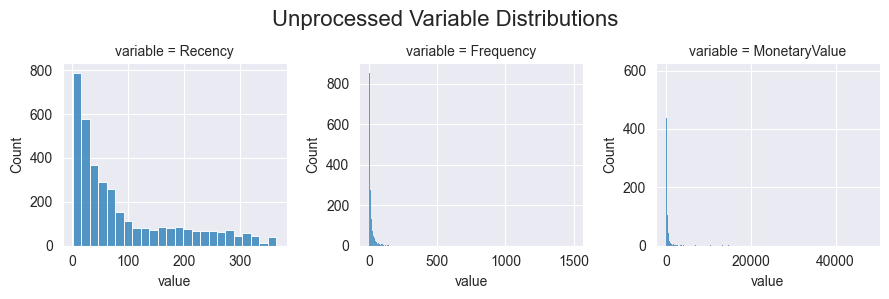

In [3]:
#set visualization style
sns.set_style('darkgrid')

# Plot the distributions of the selected variables
g=sns.FacetGrid(df_features.melt(),col='variable',sharey=False,sharex=False)

#Apply a histogram to the facet grid
g.map(sns.histplot,'value')
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle('Unprocessed Variable Distributions',size=16)
plt.show()

In [4]:
#ensure that all columns selected for clustering are numeric
all([pd.api.types.is_numeric_dtype(df_features[col]) for col in ["Recency", "Frequency", "MonetaryValue"]])

True

## 3. Pre-processing the Data
Based on the grids above, we noticed that there is skew, which needs to be removed. Therefore, the data need to be preprocessed by the following steps:
1. Unskew the data - log transformation
2. Standardize to the same average values
3. Scale to the same standard deviation
4. Store as a seperate array to be used for clustering 

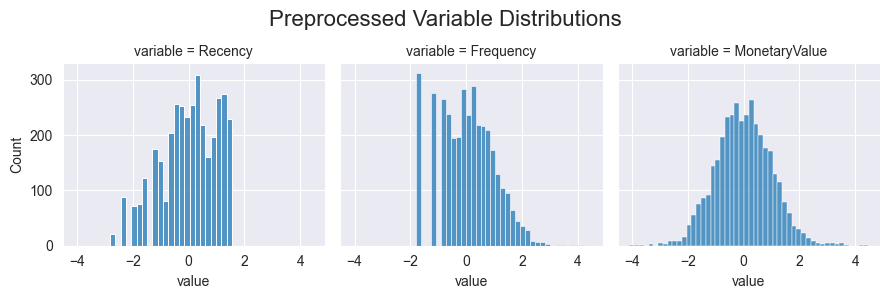

In [5]:
# unskew the data
df_log=np.log(df_features)
# transform and normalize variabels 
scaler=StandardScaler()
scaler.fit(df_log)
df_normalized=scaler.transform(df_log)
df_processed=pd.DataFrame(data=df_normalized,index=df_features.index,columns=df_features.columns)


# Plot the distributions
g=sns.FacetGrid(df_processed.melt(),col='variable')
g.map(sns.histplot,"value")
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle('Preprocessed Variable Distributions',size=16)
plt.show()

## 4. Choosing the Number of Clusters

The next step is to fit a variable number of clusters and plot each cluster's sum-of-squared errors (SSE). The SSE reflects the sum of squared distances from every data point to the cluster center. The aim is to reduce the SSE while still maintaining a reasonable number of clusters. 

By plotting the SSE for each number of clusters, we can identify at what point there are diminishing returns by adding new clusters. This type of plot is called an elbow plot.

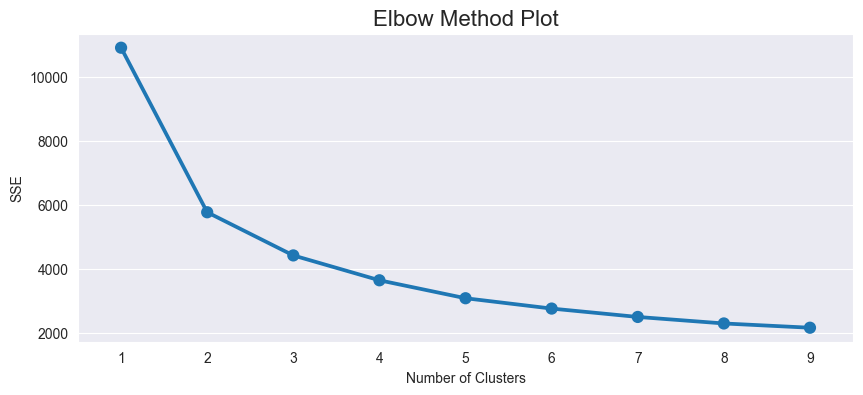

In [14]:
# Set the maximum number of clusters to plot
max_clusters = 10

# Fit KMeans and calculate SSE for each k\
sse = {}
for k in range(1, max_clusters):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(df_processed)
    sse[k] = kmeans.inertia_

# Plot the sse
plt.figure(figsize=(10, 4))
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.title("Elbow Method Plot", size=16)  
plt.xlabel("Number of Clusters")  
plt.ylabel("SSE") 
plt.show()

## 5. Clustering the Data
After observing the elbow plot,we select an optimal number of clusters by setting `k` to 3.

In [13]:
# Choose number of clusters
k = 3

# Clustering the data
kmeans = KMeans(n_clusters=k, random_state=1) 
kmeans.fit(df_processed)
cluster_labels = kmeans.labels_
df_clustered = df.assign(Cluster=cluster_labels)

# Preview the clustered DataFrame
df_clustered

,CustomerID,Recency,Frequency,MonetaryValue,Cluster
0,12747,3,25,948.70,0
1,12748,1,888,7046.16,0
2,12749,4,37,813.45,0
3,12820,4,17,268.02,0
4,12822,71,9,146.15,2
...,...,...,...,...,...
3638,18280,278,2,38.70,1
3639,18281,181,2,31.80,1
3640,18282,8,2,30.70,1
3641,18283,4,152,432.93,0


## 6. Inspecting the Clusters
### 6a. Visualizing the Raw Values by Cluster
Then, we analyze the unprocessed data by cluster. The mean values per cluster are visualized. 

   Cluster  size
0        0   901
1        1  1156
2        2  1586


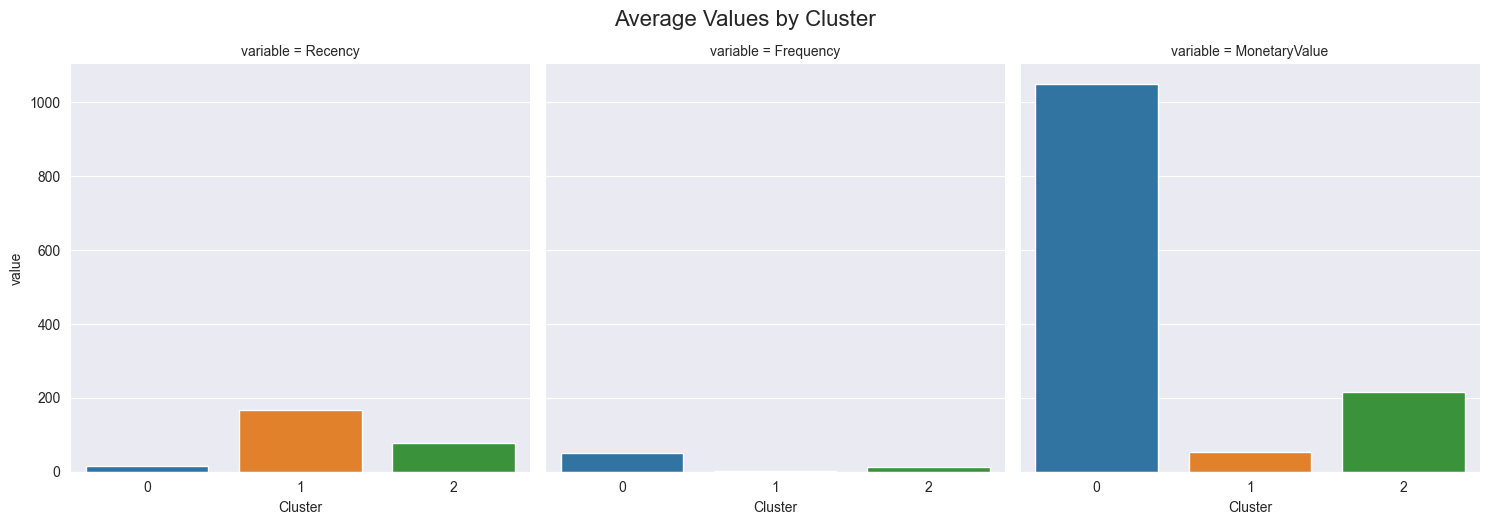

In [17]:
# Group the data by cluster and calculate the total number of rows per group
df_sizes = df_clustered.groupby(["Cluster"], as_index=False).size()
print(df_sizes)

# Calculate the mean of feature columns by cluster
df_means = df_clustered.groupby(["Cluster"])[df_features.columns].mean().reset_index()

# Plot the distributions of the selected variables
sns.catplot(
    data=df_means.melt(id_vars="Cluster"),  # Transform the data to enable plotting
    col="variable",
    x="Cluster",
    y="value",
    kind="bar",
)
plt.suptitle("Average Values by Cluster", y=1.04, fontsize=16)
plt.show()

### 6b. Create a Snake Plot of the Clusters
The next step takes the processed data and visualizes the differences between the clusters using a snake plot. We can spot trends or key differences that would not be visible with the raw data.
1. Adds the cluster labels to the processed data.
2. Transforms the data from wide to long format, which makes plotting easier.
3. Snake plot for each cluster.

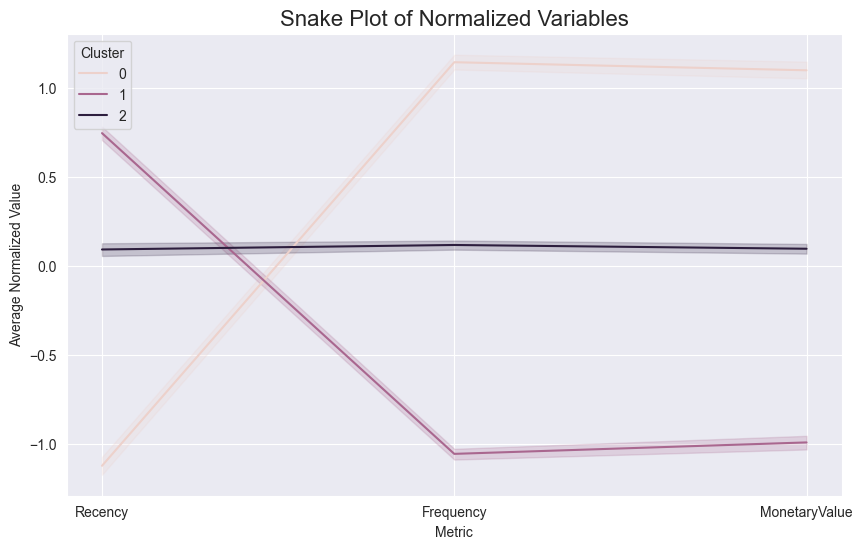

In [10]:
# Assign cluster labels to processed DataFrame
df_processed_clustered = df_processed.assign(Cluster=cluster_labels)

# Melt the normalized DataFrame and reset the index
df_processed_melt = pd.melt(
    df_processed_clustered.reset_index(),
    # Assign the cluster labelss as the ID
    id_vars=['Cluster'],
    # Assign clustering variables as values
    value_vars=df_features.columns,
    # Name the variable and value
    var_name="Metric",
    value_name="Value",
)

# Change the figure size
plt.figure(figsize=(10, 6))

# Add label and titles to the plot
plt.title('Snake Plot of Normalized Variables', fontsize=16)
plt.xlabel('Metric')
plt.ylabel('Average Normalized Value')

# Plot a line for each value of the cluster variable
sns.lineplot(data=df_processed_melt, x='Metric', y='Value', hue='Cluster')
plt.show()

### 6c. Create a Heatmap of Relative Importances
Plot the relative importance to visualize how each segment is distinct is to plot the relative importance. The method of calculate the relative importance is as follows:
1. Calculates the average values for each cluster.
2. Calculates the average values for the total population.
3. Divides the cluster averages by the population averages and subtracts one.


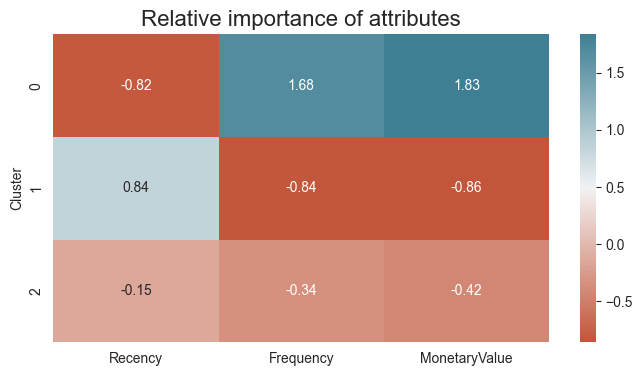

In [11]:
# Calculate average RFM values for each cluster
cluster_avg = df_clustered.groupby(["Cluster"])["Recency", "Frequency", "MonetaryValue"].mean()

# Calculate average RFM values for the total customer population
population_avg = df[["Recency", "Frequency", "MonetaryValue"]].mean()

# Calculate relative importance of cluster's attribute value compared to population
relative_imp = cluster_avg / population_avg - 1

# Plot the heatmap
plt.figure(figsize=(8, 4))
plt.title("Relative importance of attributes", fontsize=16)
sns.heatmap(data=relative_imp, annot=True, fmt=".2f", cmap=sns.diverging_palette(20, 220, as_cmap=True))
plt.show()